# Dependencies and Data

In [1]:
import requests
from datetime import datetime, timedelta
import pandas as pd
from bs4 import BeautifulSoup


import os
import re
#!pip install emoji
import emoji
import pandas as pd
import numpy as np
from collections import Counter, defaultdict

#!pip install nltk
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('punkt')
sw = stopwords.words("english")

from string import punctuation
punctuation = set(punctuation)

import sqlite3
import nltk
import random
import numpy as np
from collections import Counter, defaultdict

from string import punctuation
punctuation = set(punctuation)
tw_punct = punctuation - {"#"}


#!pip install nltk
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
sw = stopwords.words("english")

In [2]:
api_key = 'ddf3dd3b643d428586df980fcad67023'

In [3]:
everything_url = 'https://newsapi.org/v2/everything'

In [4]:
start_date = datetime(2024, 1, 27).strftime('%Y-%m-%d')
start_date

'2024-01-27'

In [5]:
end_date = datetime.now().strftime('%Y-%m-%d')
end_date

'2024-02-26'

In [6]:
def grab_articles (source, apiKey, url):

  params = {'apiKey': apiKey,
            'from': start_date,
            'to': end_date,
            'language': 'en',
            'sources': source}#, 'country': 'us',}

  response = requests.get(url, params=params)

  data = response.json()
  articles_list = []
  for article in data.get('articles', data['articles']):
    articles_list.append({'source': source, 'content': article.get('content')})

  #content = [{article.get('content')} for article in data.get('articles', [])]
  content = [{data['articles'][0].get('content')}]


  df = pd.DataFrame(articles_list)

  return df

In [7]:
fox = grab_articles('fox-news', api_key, everything_url)
# Filtering rows based on the condition
condition = ~fox['content'].str.startswith('Join Fox News for access to this content')
filtered_fox = fox[condition]

# Display the filtered DataFrame
len(filtered_fox)

52

In [8]:
cnn = grab_articles('cnn', api_key, everything_url)
# Filtering rows based on the condition
condition = ~cnn['content'].str.startswith('(CNN')
filtered_cnn = cnn[condition]
len(filtered_cnn)

100

# Clean Data

In [9]:
def clean_it(contents):    
    #remove punctuation chacters. select only the characters NOT contained in the punctuation list.
    contents_no_punc = ''.join(char for char in contents if char not in punctuation)

    #split on whitespace.
    tokens = contents_no_punc.split()

    #fold to lowercase.
    tokens_lowercased = [token.lower() for token in tokens]

    #remove stopwords.
    tokens_without_stopwords = [token for token in tokens_lowercased if token not in sw]

    #verify the token list was shortened. 
    stop_words_removed = len(tokens) - len(tokens_without_stopwords)

    #recombine tokens. 
    #cleaned_text = ' '.join(tokens_without_stopwords)
    
    return tokens_without_stopwords

In [10]:
filtered_fox['cleaned'] = filtered_fox['content'].apply(clean_it)
filtered_fox.head()

C:\Users\Joel\AppData\Local\Temp\ipykernel_2544\3700891458.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fox['cleaned'] = filtered_fox['content'].apply(clean_it)


,source,content,cleaned
1,fox-news,<ul><li>U.N. Secretary-General António Guterre...,"[ulliun, secretarygeneral, antónio, guterres, ..."
2,fox-news,Ex-KGB agent Jack Barsky said that the arrest ...,"[exkgb, agent, jack, barsky, said, arrest, dua..."
4,fox-news,A now-retired Pittsburgh police commander has ...,"[nowretired, pittsburgh, police, commander, ch..."
5,fox-news,LOS ANGELES (AP) Southern California Edison wi...,"[los, angeles, ap, southern, california, ediso..."
10,fox-news,A Massachusetts school is embroiled in tension...,"[massachusetts, school, embroiled, tension, st..."


In [11]:
filtered_cnn['cleaned'] = filtered_cnn['content'].apply(clean_it)
filtered_cnn.head()

,source,content,cleaned
0,cnn,This page includes the show Transcript\r\nFebr...,"[page, includes, show, transcript, february, 2..."
1,cnn,Norfolk Southern CEO Alan Shaw received a 37% ...,"[norfolk, southern, ceo, alan, shaw, received,..."
2,cnn,Republicans who expressed support for in vitro...,"[republicans, expressed, support, vitro, ferti..."
3,cnn,Let them eat Corn Flakes appears to be Kellogg...,"[let, eat, corn, flakes, appears, kelloggs, ce..."
4,cnn,Nick Offerman has a message for the haters who...,"[nick, offerman, message, haters, took, issue,..."


# Descriptive Stats

In [12]:
def descriptive_stats(tokens, verbose=True) :
    #calculate values. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = (num_unique_tokens/num_tokens)
    num_characters = sum(len(item) for item in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
    #count the occurrences of each item
    item_counts = Counter(tokens)

    #five most common items
    most_common_items = item_counts.most_common(5)
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters, item_counts])

In [13]:
# Create an empty list to store the contents
fox_a = []

# Iterate through each row and append the content to the list
for index, row in filtered_fox.iterrows():
    fox_a.extend(row['cleaned'])

In [14]:
# Create an empty list to store the contents
cnn_a = []

# Iterate through each row and append the content to the list
for index, row in filtered_cnn.iterrows():
    cnn_a.extend(row['cleaned'])


In [15]:
fox_desc = descriptive_stats(fox_a)

There are 1193 tokens in the data.
There are 914 unique tokens in the data.
There are 7258 characters in the data.
The lexical diversity is 0.766 in the data.


In [16]:
cnn_desc = descriptive_stats(cnn_a)

There are 2288 tokens in the data.
There are 1472 unique tokens in the data.
There are 13760 characters in the data.
The lexical diversity is 0.643 in the data.


In [17]:
def descriptive_stats(tokens, topx) :
    #calculate values. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = (num_unique_tokens/num_tokens)
    num_characters = sum(len(item) for item in tokens)
    
    # Use Counter to count the occurrences of each item
    item_counts = Counter(tokens)
    
    #retrive the top x common items
    most_common_items = [item for item, count in item_counts.most_common(topx)]
    most_common_freq = [count for item, count in item_counts.most_common(topx)]

        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters, most_common_items,most_common_freq])

# Most Common

In [18]:
string_to_remove = "chars"
string_to_remove2 = "…"
string_to_remove3 = "said"

fox_a = [item for item in fox_a if item != string_to_remove]
fox_a = [item for item in fox_a if item != string_to_remove2]
fox_a = [item for item in fox_a if item != string_to_remove3]

cnn_a = [item for item in cnn_a if item != string_to_remove]
cnn_a = [item for item in cnn_a if item != string_to_remove2]
cnn_a = [item for item in cnn_a if item != string_to_remove3]

In [19]:
print(descriptive_stats(fox_a, 10)[4])

['monday', 'police', 'people', 'new', 'president', 'ap', 'two', 'last', 'authorities', 'us']


In [20]:
print(descriptive_stats(cnn_a, 10)[4])

['president', 'us', 'two', 'years', 'former', 'donald', 'trump', 'new', 'monday', 'cnn']


# WordCloud

In [21]:
from matplotlib import pyplot as plt
#!pip install wordcloud
from wordcloud import WordCloud

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

### Fox Word Cloud

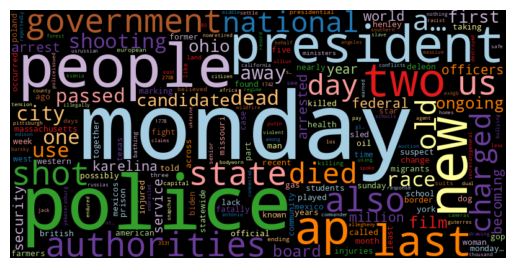

In [22]:
fox_word= Counter(fox_a)
wordcloud(fox_word)

### CNN Word Cloud

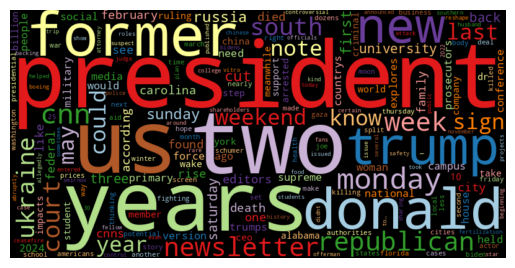

In [23]:
cnn_word= Counter(cnn_a)
wordcloud(cnn_word)

# Combine for Modeling

In [24]:
both = pd.concat([filtered_fox, filtered_cnn], ignore_index=True)
both

,source,content,cleaned
0,fox-news,<ul><li>U.N. Secretary-General António Guterre...,"[ulliun, secretarygeneral, antónio, guterres, ..."
1,fox-news,Ex-KGB agent Jack Barsky said that the arrest ...,"[exkgb, agent, jack, barsky, said, arrest, dua..."
2,fox-news,A now-retired Pittsburgh police commander has ...,"[nowretired, pittsburgh, police, commander, ch..."
3,fox-news,LOS ANGELES (AP) Southern California Edison wi...,"[los, angeles, ap, southern, california, ediso..."
4,fox-news,A Massachusetts school is embroiled in tension...,"[massachusetts, school, embroiled, tension, st..."
...,...,...,...
147,cnn,"Columbia, South CarolinaCNN\r\n — \r\nFormer ...","[columbia, south, carolinacnn, —, former, pres..."
148,cnn,At an influential gathering of conservatives t...,"[influential, gathering, conservatives, weeken..."
149,cnn,Comedian and actor Amy Schumer is sharing more...,"[comedian, actor, amy, schumer, sharing, curre..."
150,cnn,The Odysseus lunar lander is sideways on the m...,"[odysseus, lunar, lander, sideways, moon, intu..."


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [26]:
# Check the data type of the 'cleaned' column
print(type(both['cleaned'].iloc[0]))

# If it's a list, you can convert it to a single string
both['cleaned'] = both['cleaned'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Now, check the data type again
print(type(both['cleaned'].iloc[0]))

<class 'list'>
<class 'str'>


In [27]:
X = both['cleaned']
y = both['source']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [29]:
nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)

MultinomialNB()

In [30]:
y_pred = nb_model.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.7419354838709677
Classification Report:
               precision    recall  f1-score   support

         cnn       0.76      0.90      0.83        21
    fox-news       0.67      0.40      0.50        10

    accuracy                           0.74        31
   macro avg       0.71      0.65      0.66        31
weighted avg       0.73      0.74      0.72        31



# A few of guesses

In [31]:
# Assuming you have a new text in a variable named 'new_text'
new_text = "Donald trump is two years old"

# Vectorize the new text using the same CountVectorizer
new_text_vectorized = vectorizer.transform([new_text])

# Use the trained Naive Bayes model to predict the source of the new text
predicted_source = nb_model.predict(new_text_vectorized)

print(f"Predicted Source: {predicted_source[0]}")

Predicted Source: cnn


In [32]:
# Assuming you have a new text in a variable named 'new_text'
new_text = "schools are getting worse by the day"

# Vectorize the new text using the same CountVectorizer
new_text_vectorized = vectorizer.transform([new_text])

# Use the trained Naive Bayes model to predict the source of the new text
predicted_source = nb_model.predict(new_text_vectorized)

print(f"Predicted Source: {predicted_source[0]}")

Predicted Source: fox-news


In [33]:
# Assuming you have a new text in a variable named 'new_text'
new_text = "lets rally"

# Vectorize the new text using the same CountVectorizer
new_text_vectorized = vectorizer.transform([new_text])

# Use the trained Naive Bayes model to predict the source of the new text
predicted_source = nb_model.predict(new_text_vectorized)

print(f"Predicted Source: {predicted_source[0]}")

Predicted Source: cnn


In [34]:
# Assuming you have a new text in a variable named 'new_text'
new_text = "im tired of losing"

# Vectorize the new text using the same CountVectorizer
new_text_vectorized = vectorizer.transform([new_text])

# Use the trained Naive Bayes model to predict the source of the new text
predicted_source = nb_model.predict(new_text_vectorized)

print(f"Predicted Source: {predicted_source[0]}")

Predicted Source: cnn


In [35]:
# Assuming you have a new text in a variable named 'new_text'
new_text = "im tired of winning"

# Vectorize the new text using the same CountVectorizer
new_text_vectorized = vectorizer.transform([new_text])

# Use the trained Naive Bayes model to predict the source of the new text
predicted_source = nb_model.predict(new_text_vectorized)

print(f"Predicted Source: {predicted_source[0]}")

Predicted Source: cnn


# Save the model as a .pkl file to prepare for Flask

In [36]:
import joblib

# Save the trained Naive Bayes model
model_filename = "naive_bayes_model.pkl"
joblib.dump(nb_model, model_filename)

print(f"Model saved as {model_filename}")

Model saved as naive_bayes_model.pkl


In [37]:
joblib.dump(vectorizer, 'vectorizer.pkl')

['tfidf_vectorizer.pkl']